# CNN using Pytorch on the astar dataset
Goal is to use CNNs to solve the supervised learning problem for finding the correct class label for the astar dataset

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [21]:
# First let's load the dataset
from datasets.astar_dataset import make_astar_dataset
import time


# Set the grid size here
n, m = 5, 5  # grid size for the problem
N = 100000     # Number of examples

# Probability of existence of obstacle
obstacle_probability = 0.3


# Create the data set
start = time.time()
X, y = make_astar_dataset(N, n, m, obstacle_probability)
print(f"Execution time: {time.time() - start:.4f} seconds")

Execution time: 7.1953 seconds


In [22]:
import pandas as pd

# Print the statistics of each class label
y_df = pd.DataFrame(y)  # Convert y to a pandas Series if it's not already
y_df.describe()

,0,1,2,3,4
count,100000.00000,100000.00000,100000.00000,100000.00000,100000.000000
mean,0.19030,0.19030,0.19030,0.19030,0.238800
std,0.39254,0.39254,0.39254,0.39254,0.426352
min,0.00000,0.00000,0.00000,0.00000,0.000000
25%,0.00000,0.00000,0.00000,0.00000,0.000000
50%,0.00000,0.00000,0.00000,0.00000,0.000000
75%,0.00000,0.00000,0.00000,0.00000,0.000000
max,1.00000,1.00000,1.00000,1.00000,1.000000


In [23]:
# Convert the labels from one_hot vector to integer indicies
import numpy as np
y = np.argmax(y, axis=1) 

In [24]:
# Create a custom torch dataset
import torch
from torch.utils.data import Dataset, DataLoader

X_tensor = torch.from_numpy(X).float()
y_tensor = torch.from_numpy(y).long()

# Create a custom dataset class to retrieve the data
class BinaryImageDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]


# Create the dataset and dataloader classes

dataset = BinaryImageDataset(X_tensor, y_tensor)
trainloader = DataLoader(dataset, batch_size=4, shuffle=True)

torch.Size([3, 5, 5])
right


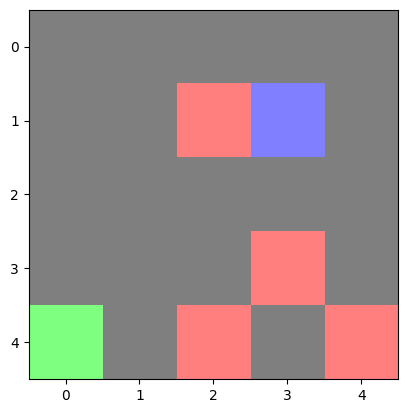

In [25]:
# Visualize some of the images
import matplotlib.pyplot as plt
import numpy as np
import torchvision

# Visualizing the dataset

classes = ("up", "left", "down", "right", "no_path")

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(trainloader)
images, labels = next(dataiter)

img = images[0]
label = labels[0].item()

print(img.shape)
# imshow(torchvision.utils.make_grid(images))
imshow(img)

print(classes[label])


In [26]:
# Let's now create a network that can solve this problem
import torch.nn as nn
import torch.nn.functional as F

class AstarNetwork(nn.Module):
    def __init__(self):
        super(AstarNetwork, self).__init__()
        self.conv1 = nn.Conv2d(3, 120, 2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(120, 480, 2)
        # self.dropout = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(480, 240)
        self.fc2 = nn.Linear(240, 120)
        self.fc3 = nn.Linear(120, 84)
        self.fc4 = nn.Linear(84, 10)


    def forward(self, x):
        x = F.leaky_relu(self.conv1(x))
        x = self.pool(x)
        x = F.leaky_relu(self.conv2(x))
        x = x.view(-1, 480)
        # x = self.dropout(x)
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = F.leaky_relu(self.fc3(x))
        x = self.fc4(x)
        return x

net = AstarNetwork()
net(img)

tensor([[ 0.0527,  0.0615,  0.0454, -0.0872, -0.0777, -0.0027, -0.0445, -0.0235,
         -0.0783,  0.0866]], grad_fn=<AddmmBackward0>)

In [ ]:
import torch.optim as optim
# Define the loss and the optimizer
criterion = nn.CrossEntropyLoss() # The cross entropy loss for classification
optimizer = optim.Adam(net.parameters(), lr=0.0001, weight_decay=1e-5)

# Train
for epoch in range(10): # Loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        # Zero gradient here is an important step
        # Gradients are accumulated over a batch, if we don't reset the gradient here we will keep accumulating gradients
        # making it impossible to train
        optimizer.zero_grad() 

        # Forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)

        loss.backward() # Compute the gradients that will direct the learning
        optimizer.step() # actually learn (one learning step)

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999: # print every 2000 minibatches
            print(f"[{epoch}, {i}] loss: {running_loss / 2000}")
            running_loss = 0.0

[0, 1999] loss: 0.22727266734711427
[0, 3999] loss: 0.213988576487778
[0, 5999] loss: 0.19804614429226222
[0, 7999] loss: 0.19061898013843104
[0, 9999] loss: 0.18713152634808589
[0, 11999] loss: 0.19350145253446738
[0, 13999] loss: 0.20071015042351323
[0, 15999] loss: 0.18514169068333536
[0, 17999] loss: 0.18736079027940175
[0, 19999] loss: 0.19299359300277139
[0, 21999] loss: 0.18784111979674942


In [30]:
# Saving the model
# There are 2 ways of saving the mode, either fully serialize it using pickle, or by saving just the params in the state dictionary

torch.save(net.state_dict(), "models/cnn_astar.pt")

In [31]:
# Training accuracy
correct = 0
total = 0
with torch.no_grad():
    for data in trainloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Training accuracy: {100 * correct / total}')

Training accuracy: 89.856


In [32]:
# Generate a test set and test on it
# Create the data set

N_test = 100000

start = time.time()
X_test, y_test = make_astar_dataset(N_test, n, m, obstacle_probability)
print(f"Execution time: {time.time() - start:.4f} seconds")

y_test = np.argmax(y_test, axis=1)


X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).long()

test_dataset = BinaryImageDataset(X_test, y_test)
testloader = DataLoader(test_dataset, batch_size=4, shuffle=True)

Execution time: 7.4611 seconds


In [33]:
# Testing accuracy

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Testing accuracy: {100 * correct / total}')

Testing accuracy: 88.328


# TODO

- Test with different model architectures
- Explore imitation learning techniques
- Explore RL techniques
Good article summarizing the different approaches that exist https://smartlabai.medium.com/a-brief-overview-of-imitation-learning-8a8a75c44a9c
- Test with imitation learning https://imitation.readthedocs.io/en/latest/index.html